# <center>Project 03: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Bùi Minh Duy
- MSSV: 23127040
- Lớp: 23CLC01

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import thêm dữ thư viện nếu cần


# Đọc dữ liệu

In [2]:
# Đọc dữ liệu  bằng pandas
train_raw = pd.read_csv('p03.train.csv')
test_raw = pd.read_csv('p03.test.csv')

print("=== XỬ LÝ DỮ LIỆU TẬP HUẤN LUYỆN ===")
print(f"Số dòng ban đầu: {len(train_raw)}")
train = train_raw.drop_duplicates(keep='first')
removed_count_train = len(train_raw) - len(train)
print(f"Số dòng trùng lặp đã loại bỏ: {removed_count_train}")
print(f"Số dòng còn lại: {len(train)}")

print("\n=== XỬ LÝ DỮ LIỆU TẬP KIỂM TRA ===")
print(f"Số dòng ban đầu: {len(test_raw)}")
test = test_raw.drop_duplicates(keep='first')
removed_count_test = len(test_raw) - len(test)
print(f"Số dòng trùng lặp đã loại bỏ: {removed_count_test}")
print(f"Số dòng còn lại: {len(test)}")

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

print(f"\nKích thước cuối cùng:")
print(f"Tập huấn luyện: {train.shape}")
print(f"Tập kiểm tra: {test.shape}")

# Sinh viên có thể sử dụng các khác nếu cần


=== XỬ LÝ DỮ LIỆU TẬP HUẤN LUYỆN ===
Số dòng ban đầu: 9000
Số dòng trùng lặp đã loại bỏ: 103
Số dòng còn lại: 8897

=== XỬ LÝ DỮ LIỆU TẬP KIỂM TRA ===
Số dòng ban đầu: 1000
Số dòng trùng lặp đã loại bỏ: 1
Số dòng còn lại: 999

Kích thước cuối cùng:
Tập huấn luyện: (8897, 6)
Tập kiểm tra: (999, 6)


# Cài đặt hàm

In [3]:
# Cài đặt các hàm cần thiết ở đây

def calculate_mse(y_true, y_pred):
    """
    Calculate Mean Squared Error (MSE)
    
    Parameters:
    y_true: True values
    y_pred: Predicted values
    
    Returns:
    float: MSE
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    mse = np.sum((y_true - y_pred) ** 2) / n
    return mse

class LinearRegression:
    """
    Linear Regression implementation using Normal Equation
    
    Model: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ
    Solution: β = (X^T X)^(-1) X^T y
    """
    
    def __init__(self):
        self.coefficients = None
        self.intercept = None
        self.feature_names = None
    
    def fit(self, X, y):
        """
        Fit the linear regression model using Normal Equation
        
        Parameters:
        X: Training features (m x n matrix)
        y: Training targets (m x 1 vector)
        """
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Store feature names if X is DataFrame
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()
        
        # Add bias column (column of ones) for intercept
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        
        # Normal Equation: β = (X^T X)^(-1) X^T y
        try:
            # Calculate X^T X
            XtX = np.dot(X_with_bias.T, X_with_bias)
            
            # Calculate (X^T X)^(-1)
            XtX_inv = np.linalg.inv(XtX)
            
            # Calculate X^T y
            Xty = np.dot(X_with_bias.T, y)
            
            # Calculate β = (X^T X)^(-1) X^T y
            beta = np.dot(XtX_inv, Xty)
            
            # Extract intercept and coefficients
            self.intercept = beta[0]
            self.coefficients = beta[1:]
            
        except np.linalg.LinAlgError:
            # If matrix is singular, use pseudo-inverse
            beta = np.dot(np.linalg.pinv(X_with_bias), y)
            self.intercept = beta[0]
            self.coefficients = beta[1:]
    
    def predict(self, X):
        """
        Make predictions using the fitted model
        
        Parameters:
        X: Features to predict (m x n matrix)
        
        Returns:
        y_pred: Predictions (m x 1 vector)
        """
        X = np.array(X)
        
        # y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ
        predictions = self.intercept + np.dot(X, self.coefficients)
        return predictions
    
    def get_params(self):
        """Return model parameters"""
        return {
            'intercept': self.intercept,
            'coefficients': self.coefficients
        }

def k_fold_cross_validation(X, y, k=5, random_state=42):
    """
    Perform k-fold cross validation
    
    Parameters:
    X: Feature matrix
    y: Target vector  
    k: Number of folds
    random_state: Random seed
    
    Returns:
    float: Average MSE from cross validation
    """
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Create indices and shuffle them
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Split indices into k folds
    fold_size = n_samples // k
    mse_scores = []
    
    for i in range(k):
        # Define test indices for current fold
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < k - 1 else n_samples
        test_indices = indices[start_idx:end_idx]
        
        # Define train indices (all except test)
        train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])
        
        # Split data
        X_train_fold = X[train_indices]
        y_train_fold = y[train_indices]
        X_test_fold = X[test_indices]
        y_test_fold = y[test_indices]
        
        # Train model on fold
        model = LinearRegression()
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on test fold
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate MSE for this fold
        mse_fold = calculate_mse(y_test_fold, y_pred_fold)
        mse_scores.append(mse_fold)
    
    # Return average MSE
    return np.mean(mse_scores)

def display_model_formula(model, feature_names):
    """
    Display regression model formula
    
    Parameters:
    model: Trained LinearRegressionFromScratch model
    feature_names: Names of features
    """
    print("\nCông thức hồi quy:")
    
    formula = f"Student Performance = {model.intercept:.3f}"
    for i, feature in enumerate(feature_names):
        coef = model.coefficients[i]
        sign = " + " if coef >= 0 else " "
        formula += f"{sign}{coef:.3f}×{feature}"
    print(formula)


*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu

Thông tin tổng quan về dữ liệu:
Kích thước tập huấn luyện: (8897, 6)
Kích thước tập kiểm tra: (999, 6)

Thông tin về các cột:
<class 'pandas.core.frame.DataFrame'>
Index: 8897 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     8897 non-null   int64  
 1   Previous Scores                   8897 non-null   int64  
 2   Extracurricular Activities        8897 non-null   int64  
 3   Sleep Hours                       8897 non-null   int64  
 4   Sample Question Papers Practiced  8897 non-null   int64  
 5   Performance Index                 8897 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 486.6 KB
None

Thống kê mô tả:
       Hours Studied  Previous Scores  Extracurricular Activities  \
count    8897.000000      8897.000000                 8897.000000   
mean        4.975497        69.387546                    

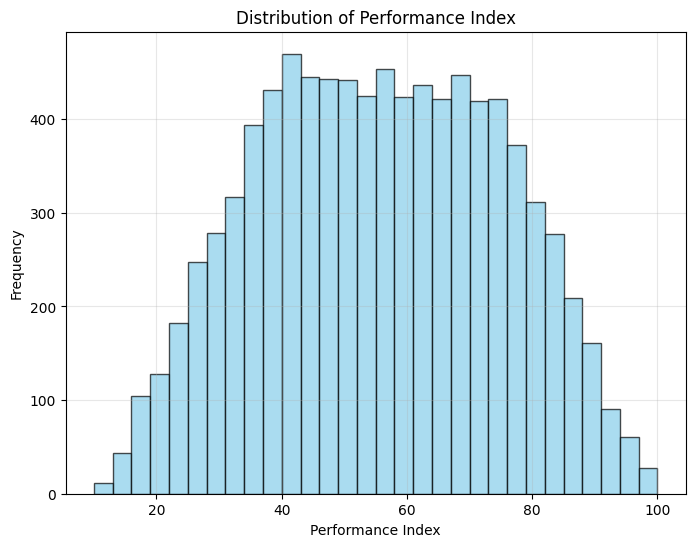

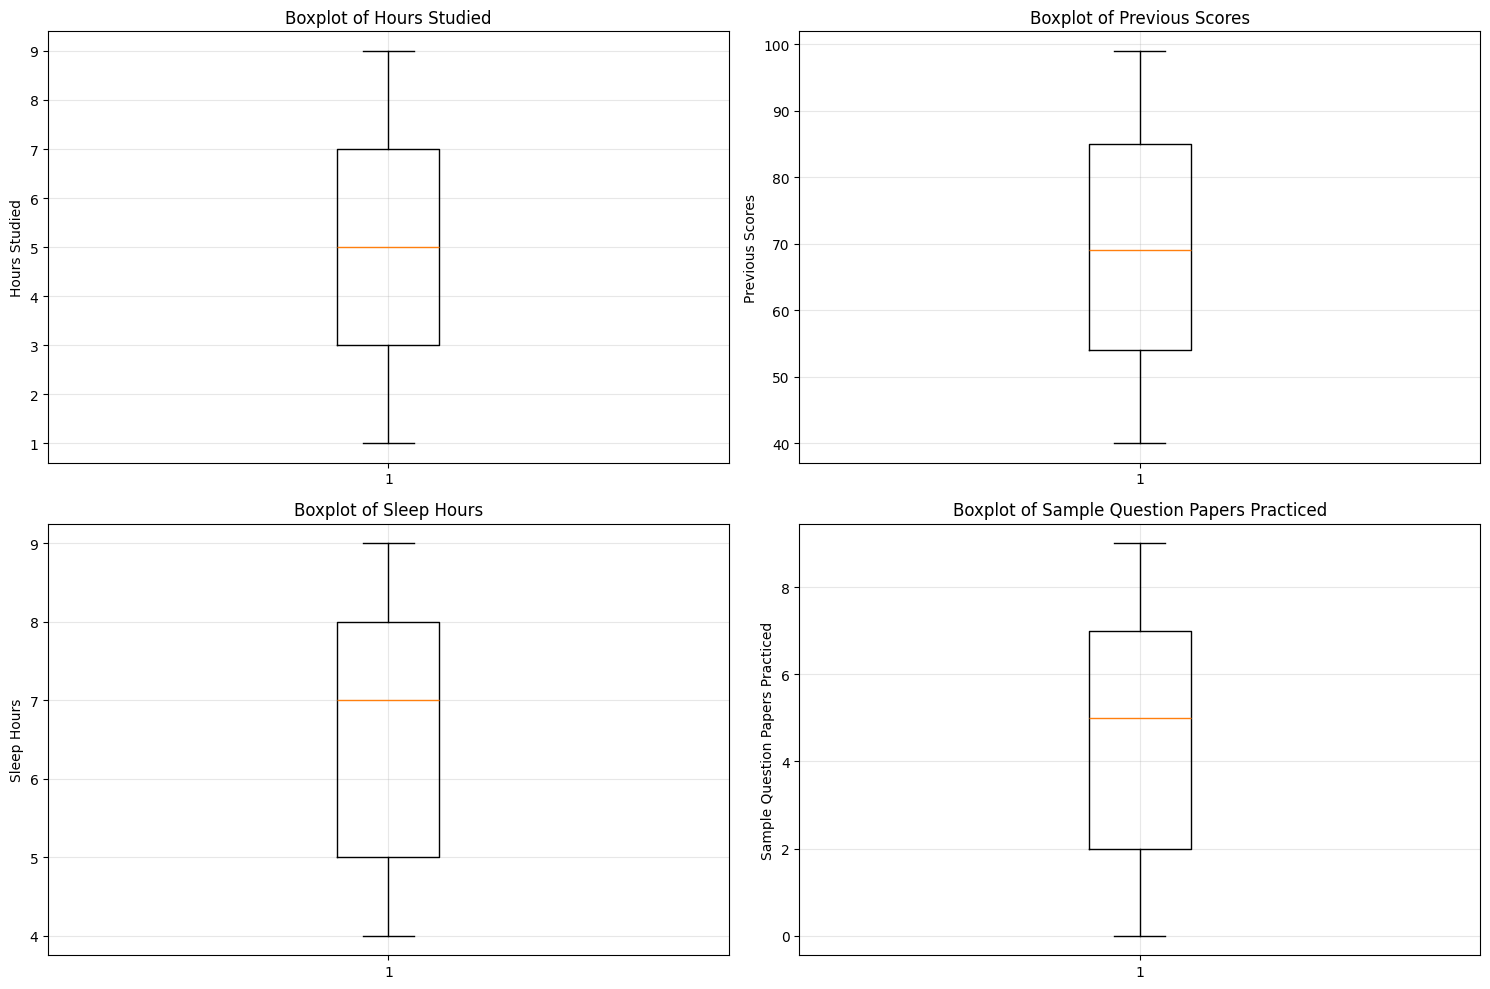

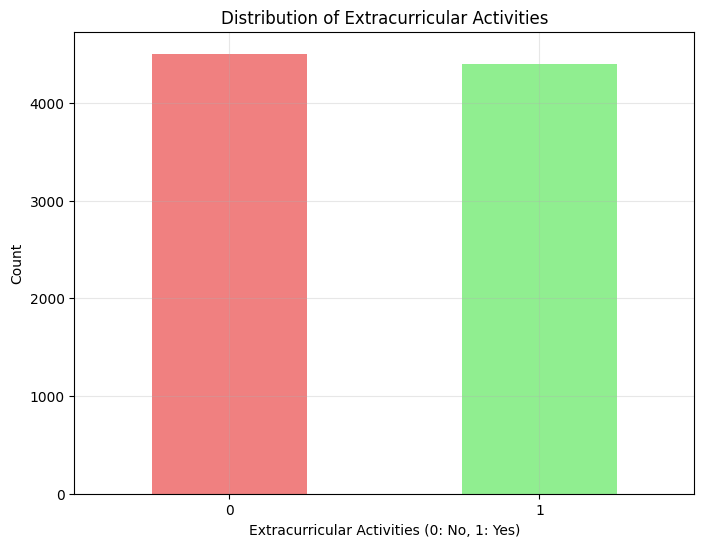

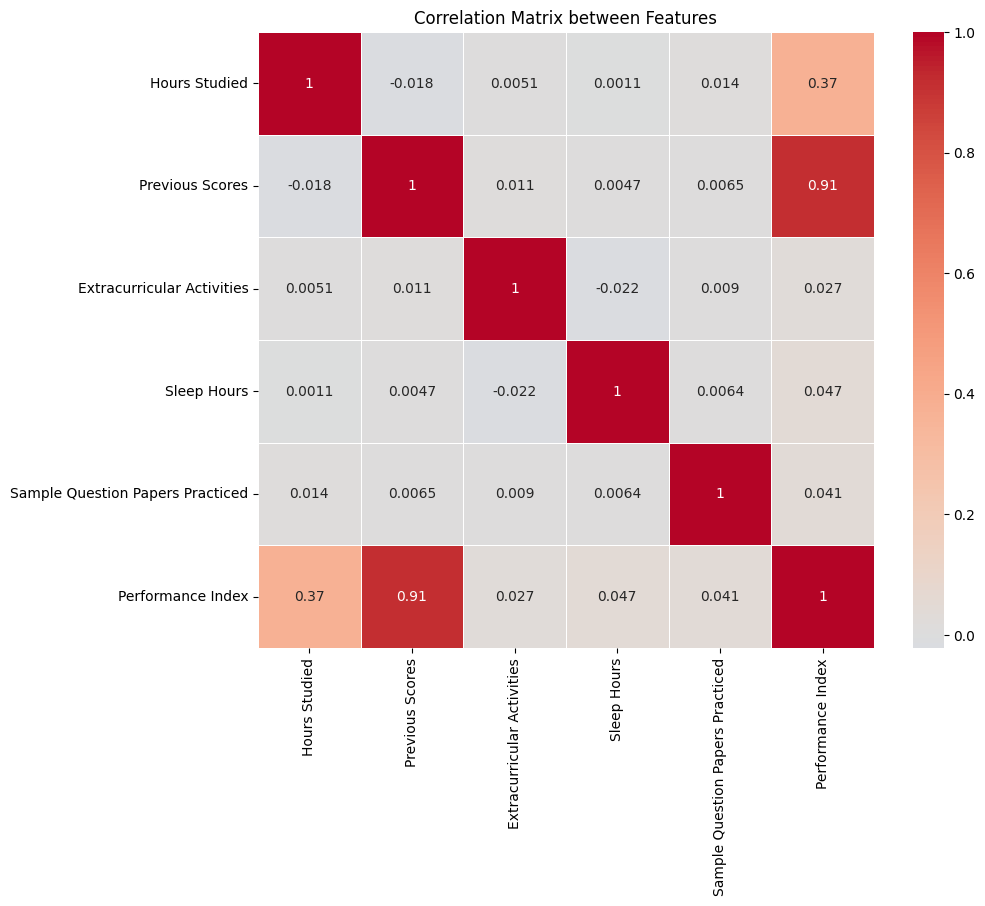

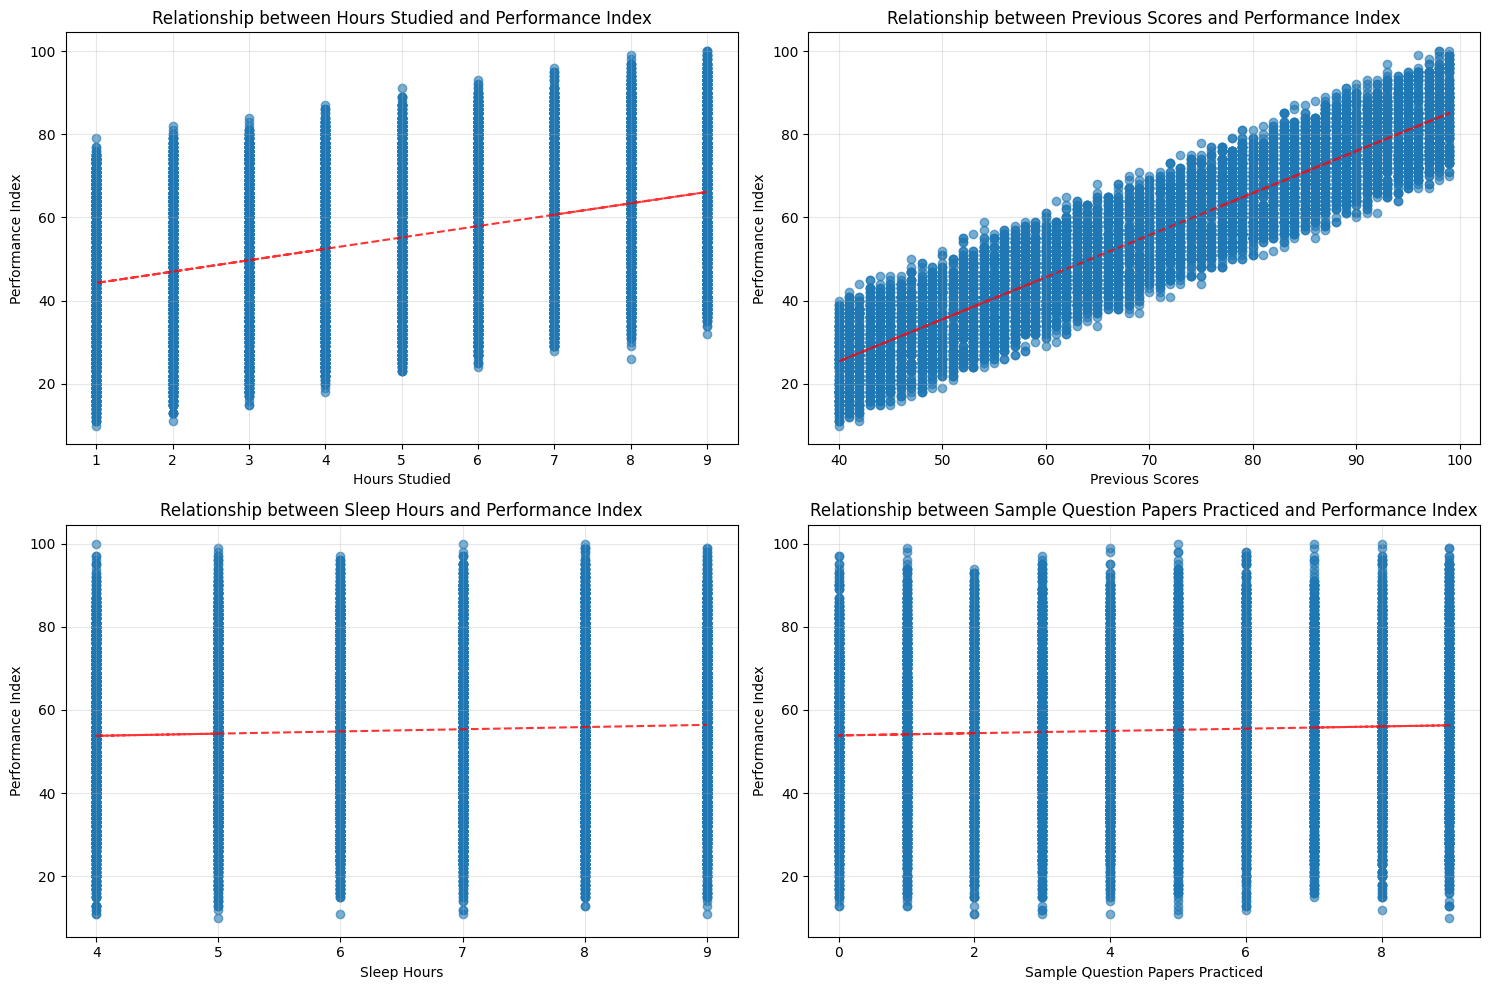

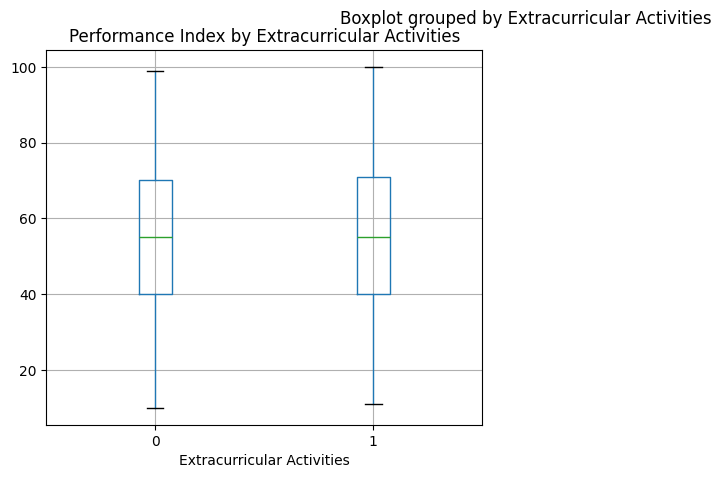

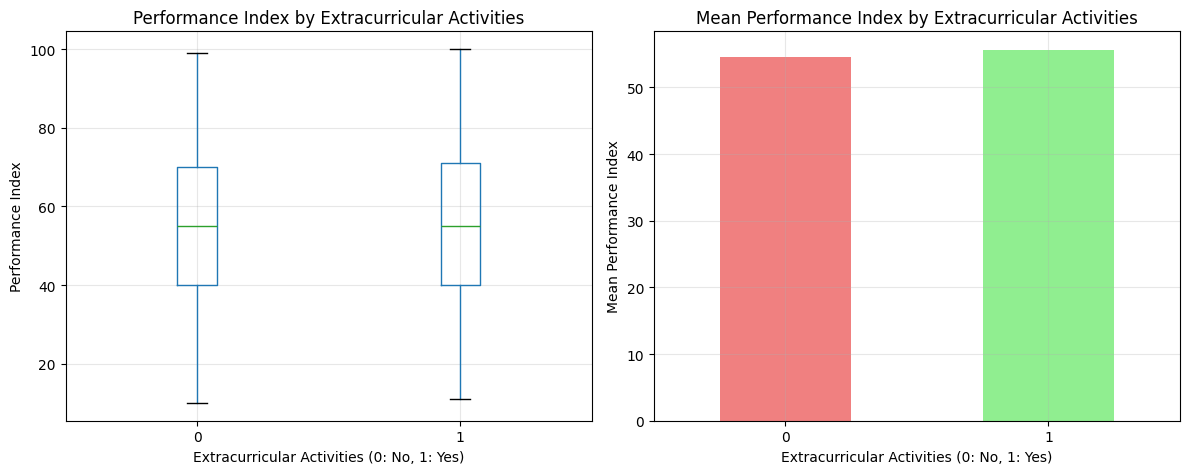


TẤT CẢ CÁC BIỂU ĐỒ ĐÃ ĐƯỢC LƯU VÀO FOLDER: 'figures'


In [4]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện

figures_folder = 'figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)
    print(f"Đã tạo folder '{figures_folder}' để lưu các biểu đồ")

print("Thông tin tổng quan về dữ liệu:")
print(f"Kích thước tập huấn luyện: {train.shape}")
print(f"Kích thước tập kiểm tra: {test.shape}")
print("\nThông tin về các cột:")
print(train.info())

print("\nThống kê mô tả:")
print(train.describe())

# Kiểm tra giá trị bị thiếu
print(f"\nGiá trị bị thiếu trong tập huấn luyện:")
print(train.isnull().sum())

# Figure 1: Distribution of target variable
plt.figure(figsize=(8, 6))
plt.hist(train['Performance Index'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Performance Index')
plt.xlabel('Performance Index')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(figures_folder, 'figure1_performance_index_distribution.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Boxplots for numerical features
plt.figure(figsize=(15, 10))
features = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(train[feature])
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_folder, 'figure2_boxplots_numerical_features.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Distribution of Extracurricular Activities
plt.figure(figsize=(8, 6))
train['Extracurricular Activities'].value_counts().plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Distribution of Extracurricular Activities')
plt.xlabel('Extracurricular Activities (0: No, 1: Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(figures_folder, 'figure3_extracurricular_activities_distribution.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Figure 4: Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix between Features')
plt.savefig(os.path.join(figures_folder, 'figure4_correlation_matrix.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Figure 5: Scatter plots showing relationships with Performance Index
plt.figure(figsize=(15, 10))
features = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.scatter(train[feature], train['Performance Index'], alpha=0.6)
    plt.xlabel(feature)
    plt.ylabel('Performance Index')
    plt.title(f'Relationship between {feature} and Performance Index')
    
    # Add regression line
    z = np.polyfit(train[feature], train['Performance Index'], 1)
    p = np.poly1d(z)
    plt.plot(train[feature], p(train[feature]), "r--", alpha=0.8)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_folder, 'figure5_scatter_plots_relationships.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Figure 6: Performance Index comparison by Extracurricular Activities
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train.boxplot(column='Performance Index', by='Extracurricular Activities', ax=plt.gca())
plt.title('Performance Index by Extracurricular Activities')
# Figure 6: Performance Index comparison by Extracurricular Activities
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train.boxplot(column='Performance Index', by='Extracurricular Activities', ax=plt.gca())
plt.title('Performance Index by Extracurricular Activities')
plt.suptitle('')  
plt.ylabel('Performance Index')
plt.xlabel('Extracurricular Activities (0: No, 1: Yes)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
extra_stats = train.groupby('Extracurricular Activities')['Performance Index'].agg(['mean', 'std', 'count'])

extra_stats['mean'].plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Mean Performance Index by Extracurricular Activities')
plt.xlabel('Extracurricular Activities (0: No, 1: Yes)')
plt.ylabel('Mean Performance Index')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_folder, 'figure6_performance_by_extracurricular.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTẤT CẢ CÁC BIỂU ĐỒ ĐÃ ĐƯỢC LƯU VÀO FOLDER: '{figures_folder}'")


# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp

In [5]:
# Phần code cho yêu cầu 2a

# Huấn luyện mô hình Linear Regression với 5 đặc trưng
model_2a = LinearRegression()
model_2a.fit(X_train, y_train)

print("Kết quả huấn luyện mô hình 2a (5 đặc trưng):")
print(f"Intercept (bias): {model_2a.intercept:.6f}")
print("Coefficients (weights):")
for i, feature in enumerate(X_train.columns):
    print(f"  {feature}: {model_2a.coefficients[i]:.6f}")


Kết quả huấn luyện mô hình 2a (5 đặc trưng):
Intercept (bias): -33.960942
Coefficients (weights):
  Hours Studied: 2.851636
  Previous Scores: 1.017782
  Extracurricular Activities: 0.606242
  Sleep Hours: 0.473357
  Sample Question Papers Practiced: 0.192172


In [6]:
# Gọi hàm MSE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
y_pred_2a = model_2a.predict(X_test)
mse_2a = calculate_mse(y_test, y_pred_2a)

print(f"MSE trên tập kiểm tra: {mse_2a:.6f}")

# Hiển thị công thức mô hình
display_model_formula(model_2a, X_train.columns)


MSE trên tập kiểm tra: 4.092356

Công thức hồi quy:
Student Performance = -33.961 + 2.852×Hours Studied + 1.018×Previous Scores + 0.606×Extracurricular Activities + 0.473×Sleep Hours + 0.192×Sample Question Papers Practiced


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.961 + 2.852 \times \text{Hours Studied} + 1.018 \times \text{Previous Scores} + 0.606 \times \text{Extracurricular Activities} + 0.473 \times \text{Sleep Hours} + 0.192 \times \text{Sample Question Papers Practiced}$$

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [7]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu

# Danh sách các đặc trưng
feature_names = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 
                'Sleep Hours', 'Sample Question Papers Practiced']

# Kết quả cross validation cho từng đặc trưng
cv_results = {}
k_folds = 5

print(f"Kết quả {k_folds}-fold Cross Validation cho từng đặc trưng:")

# Tạo danh sách để lưu kết quả
results_data = []

for i, feature in enumerate(feature_names, 1):
    # Lấy dữ liệu cho đặc trưng hiện tại
    X_single = X_train[[feature]]
    
    # Thực hiện cross validation
    mse_cv = k_fold_cross_validation(X_single, y_train, k=k_folds, random_state=42)
    cv_results[feature] = mse_cv
    
    # Thêm vào danh sách kết quả
    results_data.append({
        'STT': i,
        'Mô hình với 1 đặc trưng': feature,
        'MSE': f"{mse_cv:.6f}"
    })

results_df = pd.DataFrame(results_data)

# Tạo styled table với căn giữa
background_color = '#1e1e1e'
text_color = '#d4d4d4'

styled_table = results_df.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt',
    'border': '1px solid #d4d4d4',
    'background-color': background_color,
    'color': text_color
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('text-align', 'center'),
        ('font-weight', 'bold'),
        ('background-color', background_color),
        ('color', text_color),
        ('border', f'1px solid {text_color}')
    ]},
    {'selector': 'td', 'props': [
        ('text-align', 'center'),
        ('background-color', background_color),
        ('color', text_color),
        ('border', f'1px solid {text_color}')
    ]},
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse')
    ]}
]).hide(axis="index")

# Hiển thị bảng
display(styled_table)

# Tìm đặc trưng tốt nhất (MSE thấp nhất)
best_feature = min(cv_results, key=cv_results.get)
best_mse = cv_results[best_feature]

print(f"Đặc trưng tốt nhất: {best_feature}")
print(f"MSE Cross Validation tốt nhất: {best_mse:.6f}")


Kết quả 5-fold Cross Validation cho từng đặc trưng:


STT,Mô hình với 1 đặc trưng,MSE
1,Hours Studied,317.510929
2,Previous Scores,60.141086
3,Extracurricular Activities,367.670027
4,Sleep Hours,367.287602
5,Sample Question Papers Practiced,367.485440


Đặc trưng tốt nhất: Previous Scores
MSE Cross Validation tốt nhất: 60.141086


In [8]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện

# Lấy dữ liệu cho đặc trưng tốt nhất
X_best_train = X_train[[best_feature]]
X_best_test = X_test[[best_feature]]

# Huấn luyện mô hình với đặc trưng tốt nhất
model_2b = LinearRegression()
model_2b.fit(X_best_train, y_train)

print(f"Kết quả huấn luyện mô hình với đặc trưng tốt nhất ({best_feature}):")
print(f"Intercept (bias): {model_2b.intercept:.6f}")
print(f"Coefficient cho {best_feature}: {model_2b.coefficients[0]:.6f}")


Kết quả huấn luyện mô hình với đặc trưng tốt nhất (Previous Scores):
Intercept (bias): -15.015334
Coefficient cho Previous Scores: 1.010847


In [9]:
# Gọi hàm MSE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
y_pred_2b = model_2b.predict(X_best_test)
mse_2b = calculate_mse(y_test, y_pred_2b)

print(f"MSE trên tập kiểm tra: {mse_2b:.6f}")

# Hiển thị công thức với giá trị thực cho yêu cầu 2b
display_model_formula(model_2b, [best_feature])


MSE trên tập kiểm tra: 58.906757

Công thức hồi quy:
Student Performance = -15.015 + 1.011×Previous Scores


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -15.015 + 1.011 \times \text{Previous Scores}$$

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất

## Xây dựng/Thiết kế mô hình

In [10]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình

# Mô hình 1: Sử dụng 2 đặc trưng tốt nhất
print("Mô hình 1: Hours Studied + Previous Scores (2 đặc trưng)")
def create_model1_features(X):
    return X[['Hours Studied', 'Previous Scores']]

# Mô hình 2: Sử dụng 3 đặc trưng tốt nhất
print("Mô hình 2: Hours Studied + Previous Scores + Extracurricular Activities (3 đặc trưng)")
def create_model2_features(X):
    return X[['Hours Studied', 'Previous Scores', 'Extracurricular Activities']]

# Mô hình 3: Đặc trưng polynomial
print("Mô hình 3: Previous Scores + Previous Scores^2 (polynomial)")
def create_model3_features(X):
    X_new = X[['Previous Scores']].copy()
    X_new['Previous_Scores_squared'] = X['Previous Scores'] ** 2
    return X_new

# Mô hình 4: Đặc trưng chuẩn hóa Z-score
print("Mô hình 4: Hours + Previous (Z-score normalized)")
def create_model4_features(X):
    X_new = pd.DataFrame(index=X.index)
    # Chuẩn hóa Z-score cho Hours Studied
    hours_mean = X['Hours Studied'].mean()
    hours_std = X['Hours Studied'].std()
    X_new['Hours_Normalized'] = (X['Hours Studied'] - hours_mean) / hours_std
    
    # Chuẩn hóa Z-score cho Previous Scores
    prev_mean = X['Previous Scores'].mean()
    prev_std = X['Previous Scores'].std()
    X_new['Previous_Normalized'] = (X['Previous Scores'] - prev_mean) / prev_std
    
    return X_new

# Mô hình 5: Đặc trưng tương tác và kỹ thuật
print("Mô hình 5: Đặc trưng tương tác và kỹ thuật")
def create_model5_features(X):
    X_new = pd.DataFrame(index=X.index)
    
    # Tương tác giữa Hours và Previous Scores
    X_new['Hours_x_Previous'] = X['Hours Studied'] * X['Previous Scores']
    
    # Hiệu quả học tập = Hours * Papers Practiced
    X_new['Study_Efficiency'] = X['Hours Studied'] * X['Sample Question Papers Practiced']
    
    # Tổng điểm năng lực = Previous + Extra bonus
    X_new['Total_Capability'] = X['Previous Scores'] + X['Extracurricular Activities'] * 10
    
    # Chỉ số cân bằng = Previous / Hours (để đánh giá hiệu quả)
    X_new['Balance_Index'] = X['Previous Scores'] / (X['Hours Studied'] + 1)  # +1 để tránh chia 0
    
    return X_new

# Danh sách các mô hình
models_2c = {
    '2 đặc trưng tốt nhất': create_model1_features,
    '3 đặc trưng tốt nhất': create_model2_features,
    'Đặc trưng đa thức': create_model3_features,
    'Đặc trưng chuẩn hóa z-score': create_model4_features,
    'Đặc trưng tương tác và kỹ thuật': create_model5_features
}

print(f"\nĐã thiết kế {len(models_2c)} mô hình.")


Mô hình 1: Hours Studied + Previous Scores (2 đặc trưng)
Mô hình 2: Hours Studied + Previous Scores + Extracurricular Activities (3 đặc trưng)
Mô hình 3: Previous Scores + Previous Scores^2 (polynomial)
Mô hình 4: Hours + Previous (Z-score normalized)
Mô hình 5: Đặc trưng tương tác và kỹ thuật

Đã thiết kế 5 mô hình.


## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [11]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu

print("Đánh giá các mô hình tùy chỉnh bằng k-fold Cross Validation")

# Đánh giá từng mô hình
cv_results_2c = {}
k_folds = 5

results_2c_data = []

for i, (model_name, feature_func) in enumerate(models_2c.items(), 1):
    try:
        # Tạo đặc trưng
        X_features = feature_func(X_train)
        
        # Thực hiện cross validation
        mse_cv = k_fold_cross_validation(X_features, y_train, k=k_folds, random_state=42)
        cv_results_2c[model_name] = mse_cv
        
        results_2c_data.append({
            'STT': i,
            'Mô hình': model_name,
            'MSE': f"{mse_cv:.6f}"
        })
        
    except Exception as e:
        print(f"Lỗi với mô hình {model_name}: {e}")

results_df = pd.DataFrame(results_2c_data)

# Tạo styled table với căn giữa
background_color = '#1e1e1e'
text_color = '#d4d4d4'

styled_table = results_df.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt',
    'border': '1px solid #d4d4d4',
    'background-color': background_color,
    'color': text_color
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('text-align', 'center'),
        ('font-weight', 'bold'),
        ('background-color', background_color),
        ('color', text_color),
        ('border', f'1px solid {text_color}')
    ]},
    {'selector': 'td', 'props': [
        ('text-align', 'center'),
        ('background-color', background_color),
        ('color', text_color),
        ('border', f'1px solid {text_color}')
    ]},
    {'selector': 'table', 'props': [
        ('border-collapse', 'collapse')
    ]}
]).hide(axis="index")

# Hiển thị bảng
display(styled_table)

# Tìm mô hình tốt nhất
best_model_2c = min(cv_results_2c, key=cv_results_2c.get)
best_mse_2c = cv_results_2c[best_model_2c]

print(f"Mô hình tốt nhất: {best_model_2c}")
print(f"MSE Cross Validation tốt nhất: {best_mse_2c:.6f}")


Đánh giá các mô hình tùy chỉnh bằng k-fold Cross Validation


STT,Mô hình,MSE
1,2 đặc trưng tốt nhất,5.220514
2,3 đặc trưng tốt nhất,5.136711
3,Đặc trưng đa thức,60.180196
4,Đặc trưng chuẩn hóa z-score,5.220514
5,Đặc trưng tương tác và kỹ thuật,18.505961


Mô hình tốt nhất: 3 đặc trưng tốt nhất
MSE Cross Validation tốt nhất: 5.136711


In [12]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện

print(f"\nHuấn luyện lại mô hình tốt nhất: {best_model_2c}")

# Lấy hàm tạo đặc trưng tốt nhất
best_feature_func = models_2c[best_model_2c]

# Tạo đặc trưng cho tập huấn luyện và kiểm tra
X_best_train_2c = best_feature_func(X_train)
X_best_test_2c = best_feature_func(X_test)

# Huấn luyện mô hình
model_2c = LinearRegression()
model_2c.fit(X_best_train_2c, y_train)

print(f"Kết quả huấn luyện mô hình tùy chỉnh tốt nhất:")
print(f"Intercept (bias): {model_2c.intercept:.6f}")
print("Coefficients (weights):")
for i, feature in enumerate(X_best_train_2c.columns):
    print(f"  {feature}: {model_2c.coefficients[i]:.6f}")



Huấn luyện lại mô hình tốt nhất: 3 đặc trưng tốt nhất
Kết quả huấn luyện mô hình tùy chỉnh tốt nhất:
Intercept (bias): -30.019030
Coefficients (weights):
  Hours Studied: 2.855039
  Previous Scores: 1.018223
  Extracurricular Activities: 0.580460


In [13]:
# Gọi hàm MSE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
y_pred_2c = model_2c.predict(X_best_test_2c)
mse_2c = calculate_mse(y_test, y_pred_2c)

print(f"\nMSE trên tập kiểm tra: {mse_2c:.6f}")

# Hiển thị công thức mô hình tốt nhất
display_model_formula(model_2c, X_best_train_2c.columns)



MSE trên tập kiểm tra: 5.273269

Công thức hồi quy:
Student Performance = -30.019 + 2.855×Hours Studied + 1.018×Previous Scores + 0.580×Extracurricular Activities


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -30.019 + 2.855 \times \text{Hours Studied} + 1.018 \times \text{Previous Scores} + 0.580 \times \text{Extracurricular Activities}$$